### Data Overview
Ames, Iowa: Alternative to the Boston Housing Data ( 2006 to 2010 )
- 2930 observations (Property Sales)
- Explanatory variables
    - 23 nominal - mainly dwelling structures.
    - 23 ordinal - rate various items in property.
    - 14 discrete - number of items; kitchens, bathrooms.
    - 20 continuous - typically are dimensinos.
    
Notes:
Key Words: <br>
Multiple Regression; Linear Models; Assessed Value; Group Project. <br>
Remove houses > 4000 sqft.

### Problem
- We want to view housing data via regression analysis.

### Load Libraries and Data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import pandas_profiling
import matplotlib as lib
import matplotlib.pyplot as plt

from pydataset import data 
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Import test and train set
test = pd.read_csv('Ames Housing Data/test.csv')
train = pd.read_csv('Ames Housing Data/train.csv')

# View shape of data
print('Shape of test set', test.shape)
print('Shape of train set', train.shape)

Shape of test set (1459, 80)
Shape of train set (1460, 81)


In [3]:
pandas_profiling.ProfileReport(train)


/anaconda3/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 2).')
  correlation_name=correlation_name, error=error


### Exploratory Data Analysis

#### Brief overview of each column in data set

#### View of housing price distribution

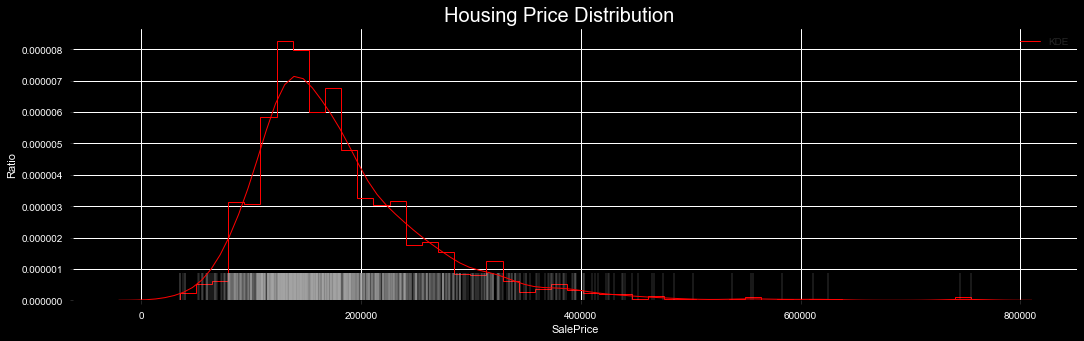

In [4]:
lib.rcParams['figure.facecolor']= 'black'
lib.rcParams['axes.facecolor']= 'black'
lib.rcParams['lines.markersize'] = 10
lib.rcParams["scatter.marker"] = '.' 
lib.rcParams['figure.titlesize']= 100
lib.rcParams['figure.figsize']=(18, 5)

plt.xticks(color='w')
plt.xlabel('Price', color='w')
plt.ylabel('Ratio', color='w')
plt.yticks(color='w')
plt.figtext(.5,.9,'Housing Price Distribution', fontsize=20, ha='center', color='w')

ax = sns.distplot(train.SalePrice, rug=True, 
                  rug_kws={"color": "darkgrey", "lw": .3, "height":.1, 'alpha':1},
                  kde_kws={"color": "r", "lw": 1, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha":1, "color": "r"})

#### Review kurtosis and Skew

In [5]:
#skewness and kurtosis
print("Skewness: ", train['SalePrice'].skew(), '| Biased towards the right due to a few high outliers.')
print("Kurtosis: ", train['SalePrice'].kurt(), '| Sharpness of peak, normal dist = 3')
print('Average House Price: ', round(train['SalePrice'].mean()))

Skewness:  1.8828757597682129 | Biased towards the right due to a few high outliers.
Kurtosis:  6.536281860064529 | Sharpness of peak, normal dist = 3
Average House Price:  180921.0


#### Review price to sqft to find outliers 

Text(0.5, 0.9, 'Housing | Price Vs. Sqft')

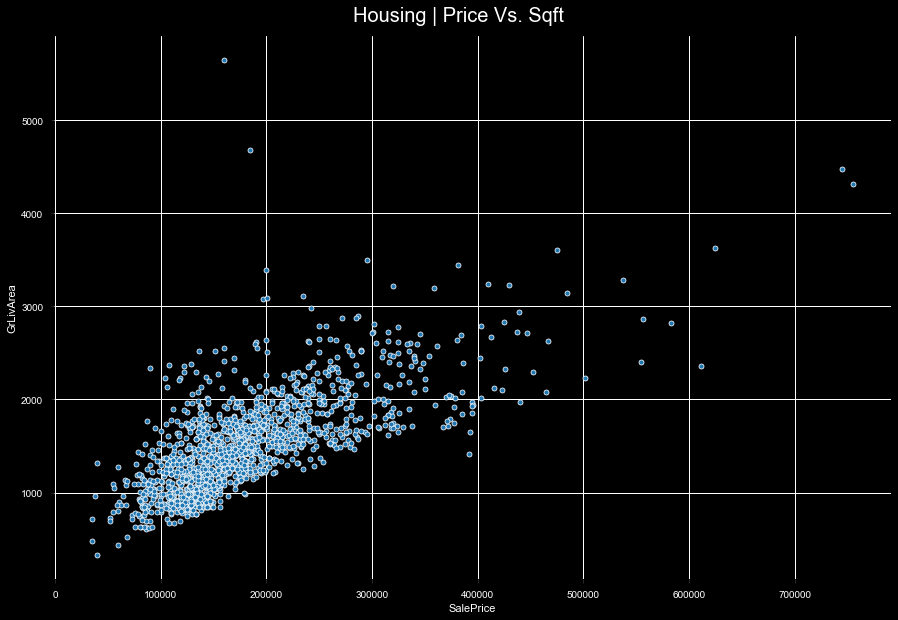

In [6]:
lib.rcParams['figure.facecolor']= 'black'
lib.rcParams['axes.facecolor']= 'black'
lib.rcParams['lines.markersize'] = 10
lib.rcParams["scatter.marker"] = '.' 
lib.rcParams['figure.titlesize']= 100
lib.rcParams['figure.figsize']=(15, 10)

plt.xticks(color='w')
plt.xlabel('Price', color='w')
plt.ylabel('Squarefoot', color='w')
plt.yticks(color='w')
sns.scatterplot(data=train, x='SalePrice', y='GrLivArea', )
plt.figtext(.5,.9,'Housing | Price Vs. Sqft', fontsize=20, ha='center', color='w')

#### Remove the 4 outliers, we're able to bring our data closer to a normal distribution. 

In [7]:
train = train[train['GrLivArea'] < 4000]

#### Review kurtosis and Skew again

In [8]:
#skewness and kurtosis
print("Skewness: ", train['SalePrice'].skew(), '| Biased towards the right due to a few high outliers.')
print("Kurtosis: ", train['SalePrice'].kurt(), '| Sharpness of peak, normal dist = 3')
print('Average House Price: ', round(train['SalePrice'].mean()))

Skewness:  1.5659592925562151 | Biased towards the right due to a few high outliers.
Kurtosis:  3.8852828233316745 | Sharpness of peak, normal dist = 3
Average House Price:  180151.0


#### Review Correlations

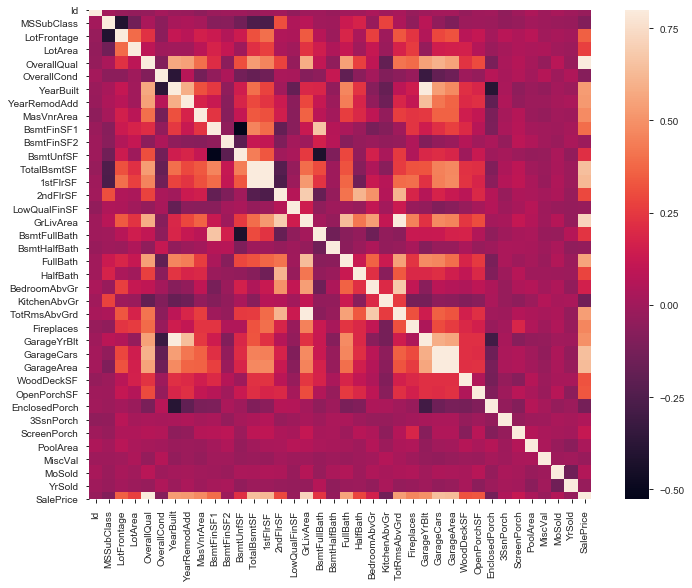

In [9]:
#correlation matrix
lib.rcParams['figure.facecolor']= 'w'

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

#### Review positive correlation and negative correlation ditributions

In [10]:
c = train.corr()
s = c.unstack()
positive_corr = s.sort_values(kind="quicksort", ascending=False)
negative_corr = s.sort_values(kind="quicksort")

In [11]:
positive_corr = positive_corr[positive_corr != 1]
negative_corr = negative_corr[negative_corr != 1]

Text(0.5, 0.9, 'Positive Correlation Distribution')

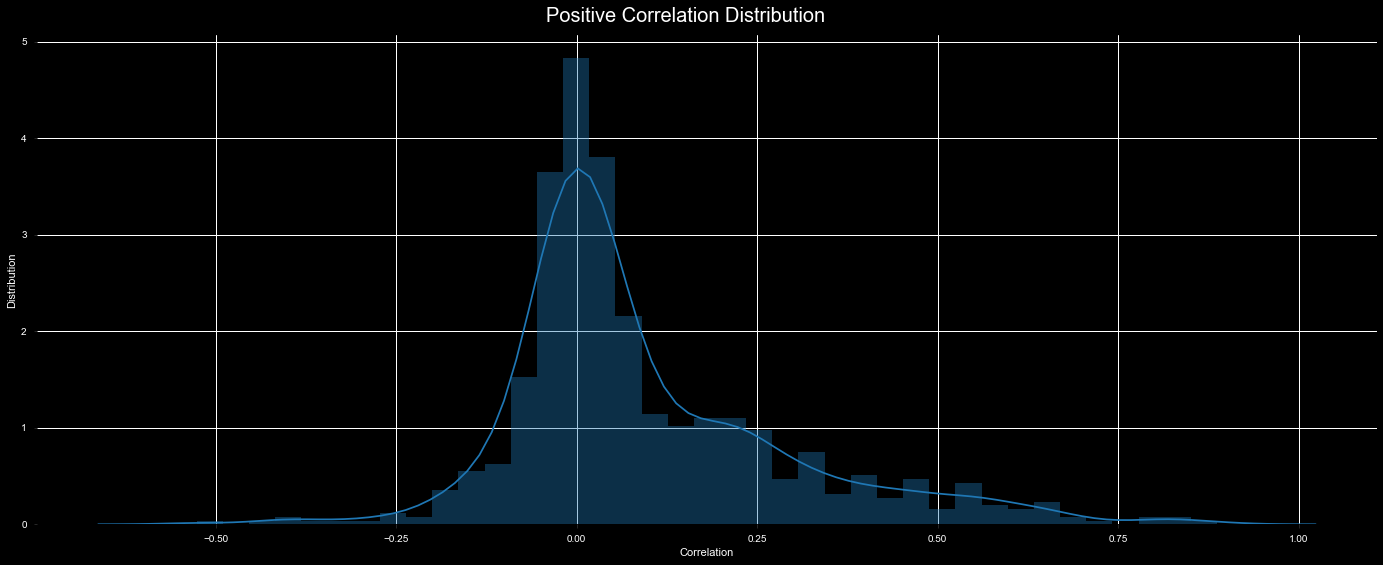

In [12]:
lib.rcParams['figure.facecolor']= 'black'
lib.rcParams['axes.facecolor']= 'black'
lib.rcParams['lines.markersize'] = 10
lib.rcParams["scatter.marker"] = '.' 
lib.rcParams['figure.titlesize']= 100
lib.rcParams['figure.figsize']=(24, 9)
plt.xticks(color='w')
plt.yticks(color='w')

plt.xlabel('Correlation', color='w')
plt.ylabel('Distribution', color='w')
sns.distplot(positive_corr)
plt.figtext(.5,.9,'Positive Correlation Distribution', fontsize=20, ha='center', color='w')

Text(0.5, 0.9, 'Negative Correlation Distribution')

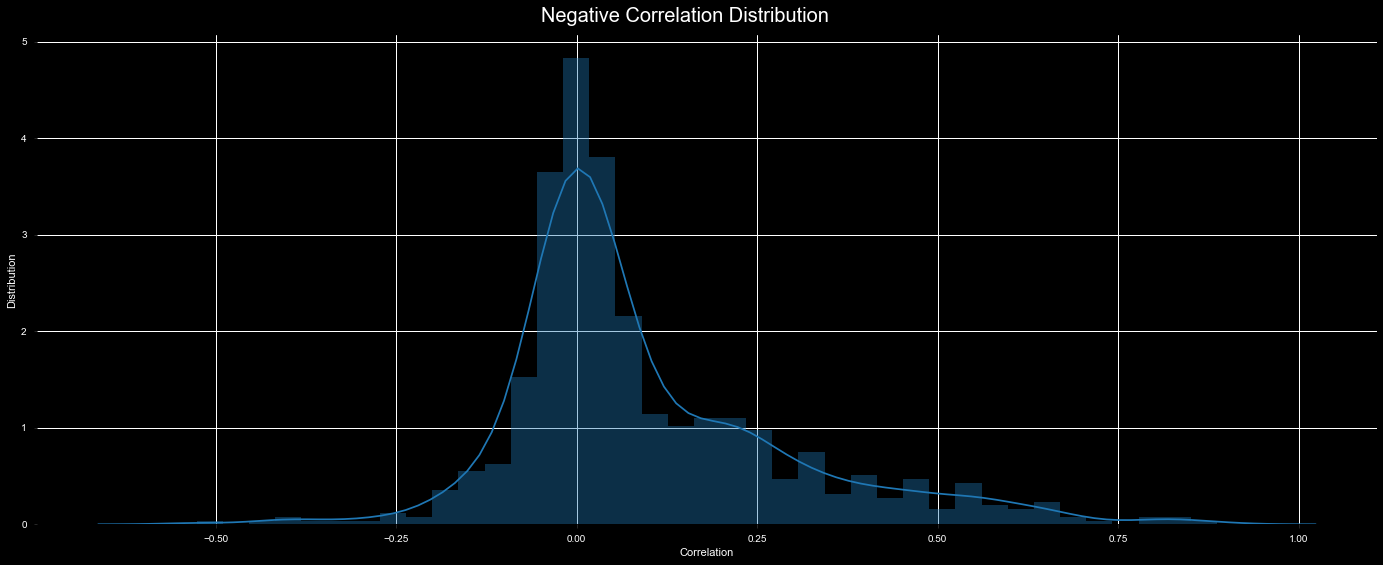

In [13]:
lib.rcParams['figure.facecolor']= 'black'
lib.rcParams['axes.facecolor']= 'black'
lib.rcParams['lines.markersize'] = 10
lib.rcParams["scatter.marker"] = '.' 
lib.rcParams['figure.titlesize']= 100
lib.rcParams['figure.figsize']=(24, 9)
plt.xticks(color='w')
plt.yticks(color='w')

plt.xlabel('Correlation', color='w')
plt.ylabel('Distribution', color='w')
sns.distplot(negative_corr)
plt.figtext(.5,.9,'Negative Correlation Distribution', fontsize=20, ha='center', color='w')

#### Clean, transform, and encode data

In [14]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Nans = no feature
feature_does_not_exist = [ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                           'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageFinish', 'GarageQual', 'GarageCond',
                           'PoolQC', 'Fence', 'MiscFeature' ]

##### Train

In [15]:
train.LotFrontage = train.LotFrontage.fillna(round(train.LotFrontage.mean()))
train.Alley = train.Alley.fillna("No access")

# Fill in select Nans
for x in feature_does_not_exist:
    train[x] = train[x].fillna('None')

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

# Turn into categorical information
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['OverallCond'] = train['OverallCond'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

# Labelencode
for x in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(pd.Series(train[x].values)))
    train[x] = lbl.transform(list(pd.Series(train[x].values)))

#### View skewness

In [16]:
numeric = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train[numeric].apply(lambda x: pd.DataFrame.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Skew
MiscVal       24.443364
PoolArea      17.522613
LotArea       12.587561
3SsnPorch     10.289866
LowQualFinSF   8.998564
LandSlope      4.806279
KitchenAbvGr   4.481366
BsmtFinSF2     4.248587
BsmtHalfBath   4.128967
ScreenPorch    4.115641

#### Fix Skewness

In [17]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

#### Get dummies

In [18]:
train = pd.get_dummies(train)

In [19]:
train[train==np.inf]=np.nan
train.fillna(train.mean(), inplace=True)

In [20]:
X_train = train
y_train = train.SalePrice

#### Modelling

- Kfold function randomizes our data, and splits it into train/test sets.
- After kfold -- run cross valiation. This runs our given model on the number of folds that we have specified. 
    - This allows us to run a test on each section of our training data. 

In [21]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### Lasso Regression
- 

In [23]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0006 (0.0000)



#### Elastic Net
- Linear regression with combined L1 and L2 priors as regularizer.


In [24]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0008 (0.0000)



#### Kernel ridge score

In [25]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0455 (0.0059)



#### Gradient Boost Regression


In [26]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.4439 (0.0246)



#### XG Boost Regression

In [27]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 0.2112 (0.0250)



#### LGBM Regression

In [28]:

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.3663 (0.0335)



In [29]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [30]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1140 (0.0061)

